In [31]:
from typing import Annotated, TypedDict, Sequence   
from langchain_core.messages import BaseMessage, SystemMessage, ToolMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from dotenv import load_dotenv

load_dotenv(override=True)

True

In [32]:
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages] 

Use @tool decorator from *langchain_core.tools* 

In [ ]:
@tool
def add_numbers(num1: int, num2: int) -> int:
    """Tool function to add two numbers"""
    return num1 + num2

@tool
def sub_numbers(num1: int, num2: int) -> int:
    """Tool function to subtract two numbers"""
    return num1 - num2

@tool
def mul_numbers(num1: int, num2: int) -> int:
    """Tool function to multiply two numbers"""
    return num1 * num2

@tool
def dev_numbers(num1: int, num2: int) -> int:
    """Tool function to divide two numbers"""
    return num1 / num2


tools = [add_numbers, sub_numbers, mul_numbers, dev_numbers]  # List of tools that the agent can use

LLM instance with *.bind_tools(tools)*

In [34]:
llm = ChatOpenAI(model="gpt-4o-mini").bind_tools(tools)

Create Nodes (*llm_call* and *tool_node*)

In [35]:
def llm_call(state: State) -> State:
    system_prompt = SystemMessage(content="You are a helpful assistant that can perform various tasks using tools.")
    response = llm.invoke([system_prompt]+state['messages'])  # Pass the system prompt along with the current message history to the LLM
    return {"messages":[response]}  # Return the new state with the LLM response added to the message history

tool_node = ToolNode(tools=tools)  # Create a ToolNode instance which will handle tool calls from the LLM

Define Router Node

In [36]:
def router(state: State) -> str:
    """Node function to determine which node to route to based on the current state."""
    
    last_message = state['messages'][-1]    # Get the last message from the message history
    if last_message.tool_calls:             # Check if the last message contains any tool calls
        return "tool-needed"                # If it does, route to the tool node
    return "no_tool"                        # If it doesn't, route back to the LLM response node

Create StateGraph

In [37]:

graph = StateGraph(State)
graph.add_node("agent", llm_call)
graph.add_node("tools_node", tool_node)  # Add a ToolNode to the graph which will handle tool calls from the LLM

graph.add_conditional_edges("agent", router, {
    "tool-needed": "tools_node",
    "no_tool": END
})

graph.add_edge(START, "agent")          # Start the graph by calling the LLM response node
graph.add_edge("tools_node", "agent")   # After the tool node executes, route back to the LLM response node to get the next response from the LLM
app = graph.compile()

Display The Graph

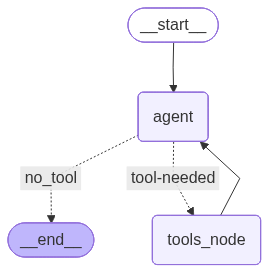

In [38]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

Add Helper Function for invocation

In [39]:
def print_stream(stream):
    for s in stream:
        message = s['messages'][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

Invoke Agent

In [42]:
input_message = {"messages":[("user", "do math 15 + 55, and then add 100, multiply all by 2 and subtract result by 50, at the end devide result by 5, but also tell me what tools do you use for this task?")]}  # Example input message to the agent
print_stream(app.stream(input_message,stream_mode="values"))


================================ Human Message =================================

do math 15 + 55, and then add 100, multiply all by 2 and subtract result by 50, at the end devide result by 5, but also tell me what tools do you use for this task?
================================== Ai Message ==================================
Tool Calls:
  add_numbers (call_pG2fFB6LujpXUKXvYcTdzy9H)
 Call ID: call_pG2fFB6LujpXUKXvYcTdzy9H
  Args:
    num1: 15
    num2: 55
  add_numbers (call_Rc0rTehmy7jg0AUK8Mwi02VP)
 Call ID: call_Rc0rTehmy7jg0AUK8Mwi02VP
  Args:
    num1:100: num1:100}}]} to=functions.add_numbers 15 + 55 + 100 = 170 and to multiply it by 2 and subtract 50 and finally divide by 5 . for that also i will use the corresponding tools.  to complete all these calculations, I will use the following functions from the `functions` namespace: 1. `add_numbers` 2. `mul_numbers` 3. `sub_numbers` 4. `dev_numbers`  to summarize all steps: 1. **Add** 15 and 55 (Using `add_numbers`). 2. **Add** 100 to